<a href="https://colab.research.google.com/github/Weverton-Vitor/multiclass-semantic-segmentation-unet/blob/main/multiclass_semantic_segmentation_with_tensorlfow_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass segmentation using TensorFlow

## 1. Mount Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 2. Import Libs

In [14]:
from keras.utils import normalize
import os
import zipfile
import glob
import random
from PIL import Image, ImageSequence
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder


## 3. Open and preprocess the dataset
In this dataset we already have the masks, so we can just open them

> Become one with the data

### 3.1 Unzip the dataset

In [15]:
dataset_zip_path = "/content/drive/MyDrive/Colab Notebooks/My Projects/datasets/sandstone_data_for_ML.zip"
with zipfile.ZipFile(dataset_zip_path) as file:
  file.extractall('./')

In [38]:
# Resize the images to this values
SIZE_X = 128
SIZE_Y = 128

# Num of classes
n_classes = 4

def get_images_from_directory(images_path: str) -> list:
  images = []
  image = Image.open(images_path)


  for frame in range(image.n_frames):
    image.seek(frame)

    images.append(image.copy())

  return images


In [17]:
images = get_images_from_directory('/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif')
masks = get_images_from_directory('/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif')

In [18]:
len(images), len(masks)

(1600, 1600)

In [37]:
images[0].size

(128, 128)

### 3.2 View some samples

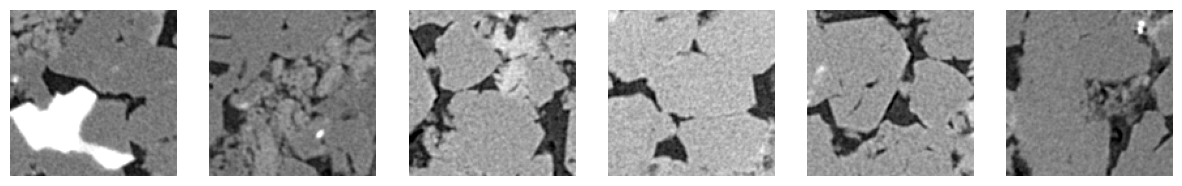

In [19]:
n_samples = 6
random_samples = random.choices(images, k=n_samples)
fig = plt.figure(figsize=(15, 15))

for i, sample in enumerate(random_samples):
  fig.add_subplot(1, n_samples, i+1)
  plt.imshow(sample, cmap='gray')
  plt.axis('off')

### 3.3 View masks

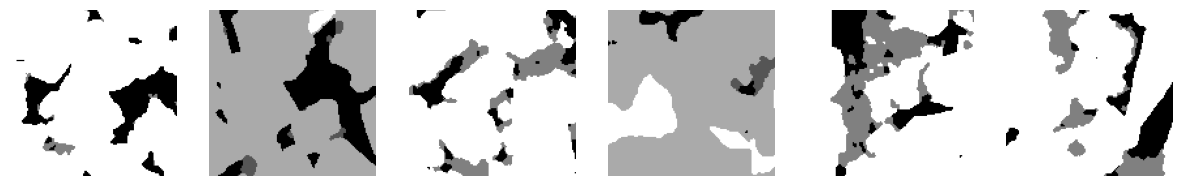

In [20]:
n_samples = 6
random_masks = random.choices(masks, k=n_samples)
fig = plt.figure(figsize=(15, 15))

for i, mask in enumerate(random_masks):
  fig.add_subplot(1, n_samples, i+1)
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

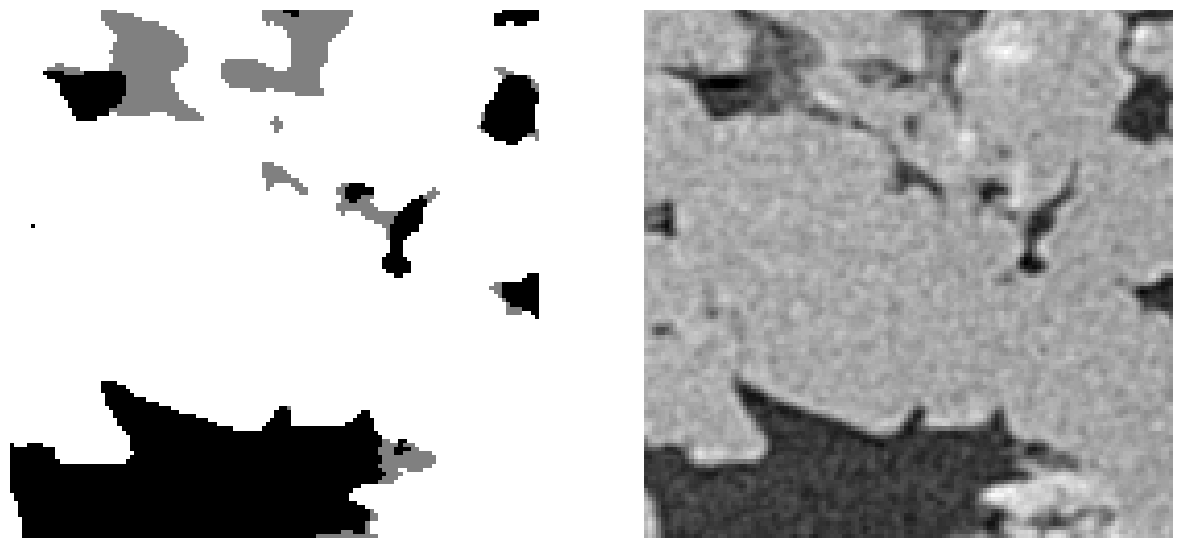

In [21]:
random_n = random.randint(0, len(masks))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(masks[random_n], cmap='gray')
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(images[random_n], cmap='gray')
plt.axis('off')


### 3.4 Preprocessing the dataset

In [22]:
# Transforms images and masks in ndarrays
train_images = np.array(images)
train_masks = np.array(masks)

In [23]:
np.unique(train_masks)

array([1, 2, 3, 4], dtype=uint8)

In [24]:
# Encode the labels
label_encoder = LabelEncoder()

# To encode our labels we need flatten it
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.flatten()
train_masks_reshaped_encoded = label_encoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

In [25]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3])

In [26]:
# Normilizing images
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks = np.expand_dims(train_masks_encoded_original_shape, axis=3)

### 3.5 Split the data

In [27]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.2)

In [28]:
np.unique(y_train)

array([0, 1, 2, 3])

In [29]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, n_class)
train_masks_cat = train_masks_cat.reshape(train_masks_cat.shape[0], train_masks_cat.shape[1], train_masks_cat.shape[2], train_masks_cat.shape[3])

test_masks_cat = to_categorical(y_test, n_class)
test_masks_cat = test_masks_cat.reshape(test_masks_cat.shape[0], test_masks_cat.shape[1], test_masks_cat.shape[2], test_masks_cat.shape[3])

### 3.6 Balance classes

In [30]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_masks_reshaped_encoded),
                                                  y=train_masks_reshaped_encoded)

In [31]:
class_weights

array([1.93354786, 3.07345989, 0.32786918, 9.30640739])

## 4. Build the Unet model

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU, Activation
from tensorflow.keras.optimizers import Adam

In [45]:
def conv_block(input, num_filters):
  x = Conv2D(filters=num_filters, # Output filters
             kernel_size=(3, 3),
             padding='same')(input) # Keep the same size
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = Conv2D(filters=num_filters,
             kernel_size=(3, 3),
             padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x

def encoder_miniblock(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D(pool_size=(2, 2))(x)
  return x, p

def decoder_miniblock(input, skip_features, num_filters):
  x = Conv2DTranspose(filters=num_filters,
                      kernel_size=(2, 2),
                      strides=(2, 2),
                      padding='same')(input)

  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def unet(input_shape, n_classes):
  inputs = Input(input_shape)
  base_filters = 64

  # Encoder
  skip1, p1 = encoder_miniblock(inputs, base_filters)
  skip2, p2 = encoder_miniblock(p1, base_filters*2)
  skip3, p3 = encoder_miniblock(p2, base_filters*4)
  skip4, p4 = encoder_miniblock(p3, base_filters*8)

  b1 = conv_block(p4, base_filters*16)

  # Decoder
  d1 = decoder_miniblock(b1, skip4, base_filters*8)
  d2 = decoder_miniblock(d1, skip3, base_filters*4)
  d3 = decoder_miniblock(d2, skip2, base_filters*2)
  d4 = decoder_miniblock(d3, skip1, base_filters)

  outputs = Conv2D(filters=n_classes,
                   kernel_size=1,
                   padding='same',
                   activation='softmax')(d4)

  model = Model(inputs, outputs, name='Unet')
  return model

In [46]:
unet_model = unet((SIZE_X, SIZE_Y, 1), n_classes)
unet_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 128, 128, 64)         640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_29 (Ba  (None, 128, 128, 64)         256       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_29 (ReLU)             (None, 128, 128, 64)         0         ['batch_normalization_29[0]